In [1]:
import datetime
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pyhdf.SD import SD, SDC 
import pyresample
from random import shuffle
from scipy import ndimage, stats
import time
import tqdm
import xarray as xr


# https://pyresample.readthedocs.io/en/latest/swath.html

In [2]:
from geonexl1b import *

# sys.path.append('/nobackupp10/tvandal/nex-ai-opticalflow/')
# from nexai.datasets.geostationary import goesr


In [3]:
def inverse_maps(H,V,size):
    Lat = np.zeros((size,size))
    Lon = np.zeros((size,size))
    R, T = 6371007.181, 1111950
    xmin, ymax = -20015109., 10007555.
    w = T /size
    y=np.array([(ymax-(i+.5)*w-V*T) for i in range(size)] )
    x =np.array([((j+.5)*w + (H)*T + xmin) for j in range(size)])
    for i,yy in enumerate(y):
        for j,xx in enumerate(x):
            ll=yy/R
            Lat[i,j]=ll*180/np.pi
            Lon[i,j]=180/np.pi*(xx/(R*np.cos(ll)))
    return Lat,Lon


def regrid(ds, lat_min, lat_max, lon_min, lon_max, name):
    lats_new = np.arange(lat_min, lat_max, 0.02)
    lons_new = np.arange(lon_min, lon_max, 0.02)
    lons_new, lats_new = np.meshgrid(lons_new, lats_new)
    source_def = pyresample.geometry.SwathDefinition(lons=ds.lon.values, lats=ds.lat.values)
    target_def = pyresample.geometry.GridDefinition(lons=lons_new, lats=lats_new)
    
    if "band" in list(ds.dims):
        arrays = []
        for b in tqdm.tqdm(ds.band.values):
            for t in ds.time.values:
                data = ds.sel(band=b).sel(time=t)[name].values
                result = pyresample.kd_tree.resample_nearest(source_def, data, target_def, radius_of_influence=50000, epsilon=0.5)
                data_new = xr.DataArray(np.expand_dims(np.expand_dims(result,-1), -1),
                                        coords=dict(lat=lats_new[:,0], lon=lons_new[0,:], time=[t], band=[b]),
                                        dims=("lat", "lon", "time", "band"))
                arrays.append(data_new)
        
    else:
        arrays = []
        for t in ds.time.values:
            data = ds.sel(time=t).dsr.values
            result = pyresample.kd_tree.resample_nearest(source_def, data, target_def, radius_of_influence=50000, epsilon=0.5)
            data_new = xr.DataArray(np.expand_dims(result,-1),
                                    coords=dict(lat=lats_new[:,0], lon=lons_new[0,:], time=[t]),
                                    dims=("lat", "lon", "time"))
            arrays.append(data_new)
            
    array_concat = xr.combine_by_coords([a.to_dataset(name=name) for a in arrays])    
    return array_concat
           

def read_MCD18A1(filename):
    file = SD(filename, SDC.READ)
    sds_obj = file.select('DSR') 
    dsr = sds_obj.get()
    tile = os.path.basename(filename).split(".")[2]
    H, V =  int(tile[1:3]), int(tile[4:6])
    lat, lon = inverse_maps(H,V,dsr.shape[-1])
    n_orbits = getattr(file, 'Orbit_amount')
    orbit_time_stamps = getattr(file, 'Orbit_time_stamp').split("\n")[:n_orbits]
    ds = xr.Dataset(data_vars=dict(dsr=(["time", "x", "y"], dsr)),
                    coords=dict(lon=(["x", "y"], lon),
                                lat=(["x", "y"], lat),
                                time=orbit_time_stamps))
    
    lat_min, lat_max = np.nanmin(ds.lat), np.nanmax(ds.lat)
    lon_min, lon_max = np.nanmin(ds.lon), np.nanmax(ds.lon)
    
    ds = regrid(ds, lat_min, lat_max, lon_min, lon_max, "dsr")
    ds = ds.where(ds['dsr'] > 1e-6) 

    return ds, lat_min, lat_max, lon_min, lon_max


def read_MOD10_L2(MCD18A1):
    data = []
    for t in MCD18A1.time.values:
        files = "/nobackupp13/kmduffy1/MOD10L2.v061/MOD10_L2.A%s.%s.*.hdf" %(t[:-4], t[-4:])
        file_name = glob.glob(files)[0]
        file = SD(file_name, SDC.READ)
        sds_obj = file.select('NDSI_Snow_Cover')
        data.append(sds_obj.get())
        
    #####################################
    ####### need geolocation data #######
    #####################################
    # lat = 
    # lon = 

#     ds = xr.Dataset(data_vars={snow_cover:(["time", "x", "y"], np.stack(np.array(data)))},
#                     coords=dict(lon=(["x", "y"], lon),
#                                 lat=(["x", "y"], lat),
#                                 time=MCD18A1.time.values))
    
def read_MOD04_3K(MCD18A1):
    pass

def read_GOES_L1B(MCD18A1, lat_min=-60, lat_max=60, lon_min=-130, lon_max=-10):
    
    directory = '/nex/datapool/geonex/public/GOES16/NOAA-L1B/ABI-L1b-RadF/'
    geo = GeoNEXL1B(directory)

    L1B = []
    for ts in tqdm.tqdm(MCD18A1.time.values):

        yyyy, doy, hh, mm = int(ts[:4]), int(ts[4:7]), int(ts[7:9]), int(ts[9:11])
        files = geo.files(year=yyyy, dayofyear=doy, hour=hh)
        if len(files) > 0:
            files = files[files.minute == np.round(mm, -1)]
        if len(files) > 0:
            geo_data = L1GFile(files, bands=list((range(1,17))), resolution_km=2.).load_xarray(ts)
            L1B.append(geo_data)

    L1B = xr.concat(L1B, dim="time")
    L1B = regrid(L1B, lat_min, lat_max, lon_min, lon_max, "L1")
    return L1B, yyyy, doy, hh, mm

def make_patches(pair, MCD18A1_file, save_dir, size=63, stride=64):

    i_dim = len(pair.lat)
    j_dim = len(pair.lon)


    for t in pair.time.values:
        ds_slice = pair.sel(time=t)
        
        for i in np.arange(0, i_dim-size, stride):
            for j in np.arange(0, j_dim-size, stride):
                
                lats, lons = ds_slice.lat, ds_slice.lon
                ds_patch = ds_slice.sel(lat=slice(lats[i], lats[i+size])).sel(lon=slice(lons[j], lons[j+size]))
                
                if np.sum(np.isnan(ds_patch.dsr)) < 1:
                    fname = os.path.basename(MCD18A1_file).split(".061.")[0] + "_%s_lat_%s_lon_%s.nc" %(t, np.round(lats[i].values,2), 
                                                                                                        np.round(lons[j].values,2))
                    ds_patch.to_netcdf(save_dir + fname)      
                    ds_patch.close()
                    

In [4]:
# - add solar angles (zenith or azimuth?)
# - clear sky model

    

In [5]:
MCD18A1_file = '/nobackupp13/kmduffy1/MCD18A1.v061/MCD18A1.A2020345.h11v04.061.2021025160154.hdf'
MCD18A1, lat_min, lat_max, lon_min, lon_max = read_MCD18A1(MCD18A1_file)
L1B, year, doy, hour, minute =  read_GOES_L1B(MCD18A1, lat_min, lat_max, lon_min, lon_max)

# pair = L1B.merge(MCD18A1)
# save_dir = "./test_patches/"
# make_patches(pair, MCD18A1_file, save_dir)


  0%|          | 0/5 [00:00<?, ?it/s]/home4/kmduffy1/LEO-GEO/data/geonexl1b.py:30: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
 20%|██        | 1/5 [00:51<03:26, 51.72s/it]/home4/kmduffy1/LEO-GEO/data/geonexl1b.py:30: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
 40%|████      | 2/5 [01:41<02:33, 51.06s/it]/home4/kmduffy1/LEO-GEO/data/geonexl1b.py:30: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
 80%|████████  | 4/5 [02:31<00:43, 43.23s/it]/home4/kmduffy1/LEO-GEO/data/geonexl1b.py:30: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
  0%|          | 0/16 [00:00<?, ?it/s]/nobackupp13/kmduffy1/miniconda3/envs/geo/lib/python3.7/site-packages/pyresample/kd_tree.py:411: RuntimeWarning: i

In [27]:
L1B, year, doy, hour, minute =  read_GOES_L1B(MCD18A1)

  0%|          | 0/5 [00:00<?, ?it/s]/home4/kmduffy1/LEO-GEO/data/geonexl1b.py:30: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
 20%|██        | 1/5 [00:40<02:43, 40.88s/it]/home4/kmduffy1/LEO-GEO/data/geonexl1b.py:30: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
 40%|████      | 2/5 [01:21<02:02, 40.83s/it]/home4/kmduffy1/LEO-GEO/data/geonexl1b.py:30: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
 80%|████████  | 4/5 [02:02<00:34, 34.69s/it]/home4/kmduffy1/LEO-GEO/data/geonexl1b.py:30: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
  0%|          | 0/16 [00:00<?, ?it/s]/nobackupp13/kmduffy1/miniconda3/envs/geo/lib/python3.7/site-packages/pyresample/kd_tree.py:411: RuntimeWarning: i

In [28]:
L1B

<xarray.Dataset>
Dimensions:  (band: 16, lat: 6000, lon: 6000, time: 4)
Coordinates:
  * lat      (lat) float64 -60.0 -59.98 -59.96 -59.94 ... 59.94 59.96 59.98
  * band     (band) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * lon      (lon) float64 -130.0 -130.0 -130.0 -129.9 ... -10.06 -10.04 -10.02
  * time     (time) object '20203451615' '20203451750' ... '20203452115'
Data variables:
    L1       (lat, lon, time, band) float32 236.57379 114.35807 ... 39.127544

In [37]:
hour, minute

(21, 15)

### Solar zenith angle (SZA)
##### SZA = cos(latitude) * cos(solar declination) * cos(hr angle) + sin(latitude) * sin(solar declination)



In [45]:
# Solar position calulcations
# https://levelup.gitconnected.com/python-sun-position-for-solar-energy-and-research-7a4ead801777

latitude,longitude = np.meshgrid(L1B.lat.values, L1B.lon.values)
date = datetime.datetime(year, 1, 1) + datetime.timedelta(doy - 1)
month, day =  date.month, date.day

greenwichtime = hour + minute / 60 
daynum = (
        367 * year
        - 7 * (year + (month + 9) // 12) // 4
        + 275 * month // 9
        + day
        - 730531.5
        + greenwichtime / 24
    )

# Mean longitude of the sun
mean_long = daynum * 0.01720279239 + 4.894967873
# Mean anomaly of the Sun
mean_anom = daynum * 0.01720197034 + 6.240040768
# Ecliptic longitude of the sun
eclip_long = (
    mean_long
    + 0.03342305518 * math.sin(mean_anom)
    + 0.0003490658504 * math.sin(2 * mean_anom)
)
# Obliquity of the ecliptic
obliquity = 0.4090877234 - 0.000000006981317008 * daynum
# Right ascension of the sun
rasc = math.atan2(math.cos(obliquity) * math.sin(eclip_long), math.cos(eclip_long))
# Declination of the sun
decl = math.asin(math.sin(obliquity) * math.sin(eclip_long))
# Local sidereal time
sidereal = 4.894961213 + 6.300388099 * daynum + np.radians(longitude)
# Hour angle of the sun
hour_ang = sidereal - rasc


In [30]:
SZA = np.cos(np.radians(latitude)) * np.cos(decl) * np.cos(hour_ang) + np.sin(np.radians(latitude)) * np.sin(decl)

In [35]:
L1B["SZA"]= (("lat", "lon"), np.degrees(SZA))

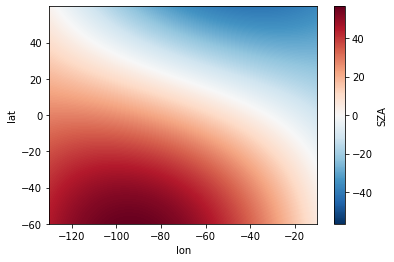

In [36]:
L1B.SZA.plot()

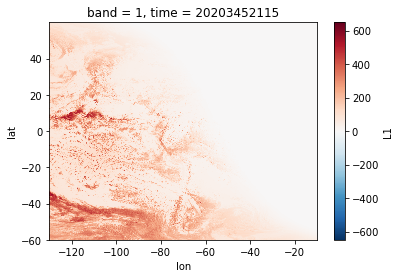

In [44]:
L1B.L1.sel(band=1).sel(time="20203452115").plot()

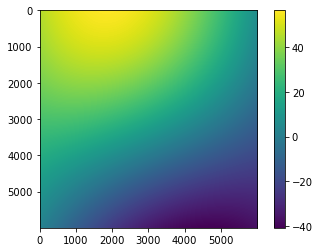

In [31]:
plt.imshow(np.degrees(SZA))
plt.colorbar()

In [19]:
filename = "/nex/datapool/geonex/public/GOES16/GEONEX-L1G/h17v12/2020/299/GO16_ABI05_20201025_1310_GLBG_h17v12_02.hdf"
file = SD(filename, SDC.READ)
# datasets_dic = file.datasets()
# for idx,sds in enumerate(datasets_dic.keys()):
#     print(idx,sds)
sds_obj = file.select('Solar_Zenith') 
sza = sds_obj.get()*0.01

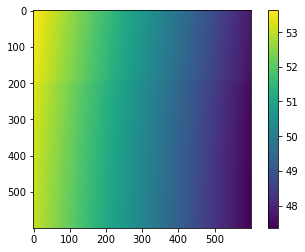

In [20]:
plt.imshow(sza)
plt.colorbar()

In [13]:
days = np.arange(0, 366, 1)

In [16]:
dec = -23.45*np.cos(np.radians(360/365*(days+10)))

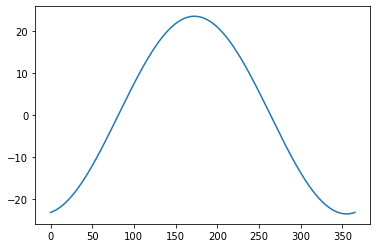

In [17]:
plt.plot(dec)

In [106]:
Rs_band = []
for b in range(1,17):
    patches = glob.glob(save_dir + "*")
    
    Rs_temp = []
    for p in patches:
        ds = xr.open_dataset(p)

        x = ds.dsr.values.flatten()
        y = ds.L1.sel(band=b).values.flatten()
        slope, intercept, r, p, se = stats.linregress(x, y)
#         print("R = %s" %np.round(r,3))
        Rs_temp.append(r)

#         fig, ax = plt.subplots(1,2,figsize=(12,5))
#         ds.dsr.plot(cmap="viridis", vmin=0, ax=ax[0])
#         ds.L1.sel(band=1).plot(cmap="viridis", vmin=0, ax=ax[1]) 
#         plt.show()  

    Rs_band.append(np.nanmean(Rs_temp))


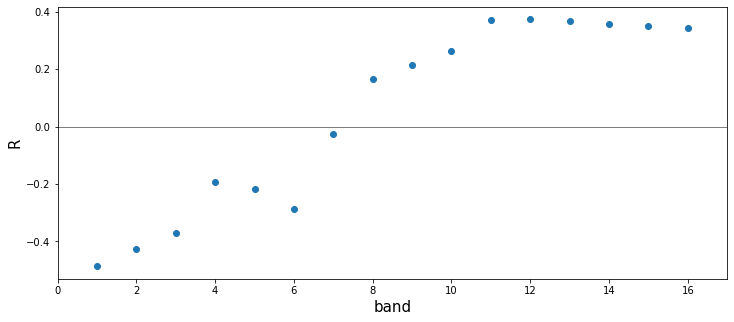

In [107]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
plt.scatter(range(1,17), Rs_band)
plt.plot([-1, 17], [0,0], lw=0.5, c="black")
plt.xlabel("band", size=15)
plt.ylabel("R", size=15)
plt.xlim(0, 17)
plt.show()


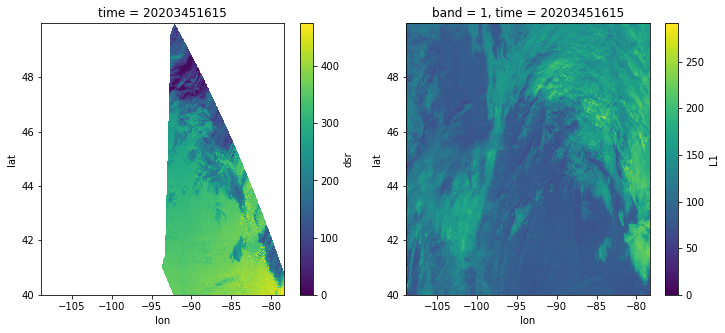

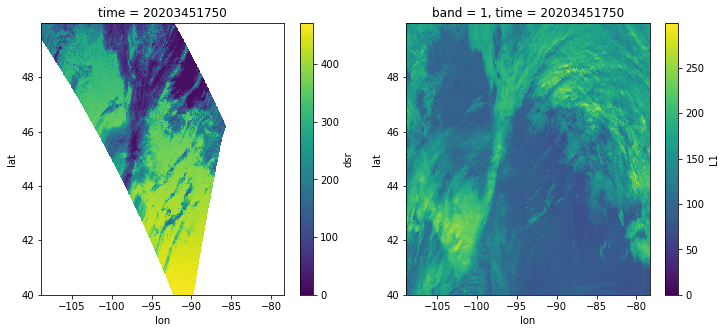

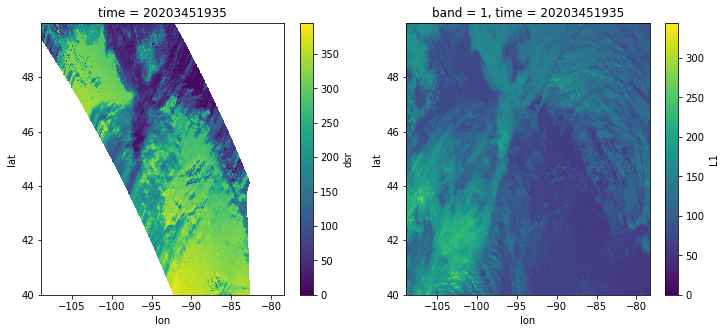

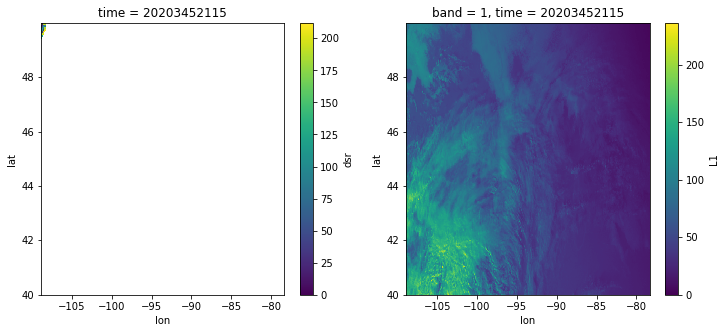

In [25]:
for t in L1B.time.values:
    fig, ax = plt.subplots(1,2,figsize=(12,5))
    MCD18A1.dsr.sel(time=t).plot(cmap="viridis", vmin=0, ax=ax[0])
    L1B.L1.sel(band=1).sel(time=t).plot(cmap="viridis", vmin=0, ax=ax[1]) 
    plt.show()
    

# L1B data to rectangular grid

In [5]:
def get_coords(resolution_km=2.):
    
    lat_0 = 60
    lon_0 = -140
    lat_1 = -60
    lon_1 = -20
    res_x = 0.01 * resolution_km
    res_y = 0.01 * resolution_km

    lats = np.arange(lat_0, lat_1, -res_y)
    lons = np.arange(lon_0, lon_1, res_x)
    
    lat2d = np.reshape(np.repeat(lats, len(lons)), (len(lats),len(lons)))
    lon2d = np.reshape(np.tile(lons, len(lats)), (len(lats),len(lons)))
 
    return lats, lons, lat2d, lon2d

In [6]:
lats, lons, lat2d, lon2d = get_coords()


### Method 1

In [ ]:
https://github.com/pydata/xarray/issues/2281

In [11]:
lon_arr = xr.DataArray(data=lat2d,
                  coords={"lat": (["x","y"], lat2d),
                          "lon": (["x","y"], lon2d)},
                  dims=["x","y"])

lat_arr = xr.DataArray(data=lon2d,
                  coords={"lat": (["x","y"], lat2d),
                          "lon": (["x","y"], lon2d)},
                  dims=["x","y"])

In [8]:
L1B_interp = L1B.interp(dict(y=lat_arr.y, x=lon_arr.x), method="nearest")

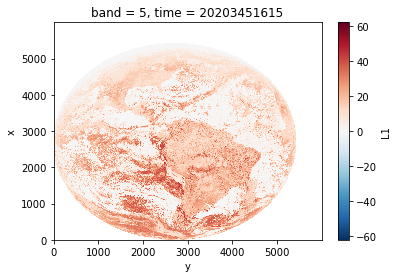

In [12]:
L1B_interp.L1.sel(time="20203451615").sel(band=5).plot()


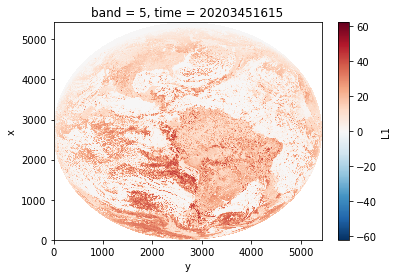

In [13]:
L1B.L1.sel(time="20203451615").sel(band=5).plot()


In [152]:
L1B_interp

<xarray.Dataset>
Dimensions:  (band: 6, time: 4, x: 6000, y: 6000)
Coordinates:
    lon      (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    lat      (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
  * band     (band) int64 1 2 3 4 5 6
  * time     (time) object '20203451615' '20203451750' ... '20203452115'
Dimensions without coordinates: x, y
Data variables:
    L1       (time, band, x, y) float32 nan nan nan nan nan ... nan nan nan nan
    y        (y) int64 0 1 2 3 4 5 6 7 ... 5993 5994 5995 5996 5997 5998 5999
    x        (x) int64 0 1 2 3 4 5 6 7 ... 5993 5994 5995 5996 5997 5998 5999

In [153]:
L1B

<xarray.Dataset>
Dimensions:  (band: 6, time: 4, x: 5424, y: 5424)
Coordinates:
    lon      (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    lat      (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
  * band     (band) int64 1 2 3 4 5 6
  * time     (time) object '20203451615' '20203451750' ... '20203452115'
Dimensions without coordinates: x, y
Data variables:
    L1       (time, band, x, y) float32 nan nan nan nan nan ... nan nan nan nan

### Method 2

In [14]:
import pyresample
orig_def = pyresample.geometry.SwathDefinition(lons=L1B.lon.values, lats=L1B.lat.values)
targ_def = pyresample.geometry.SwathDefinition(lons=lon2d, lats=lat2d)


In [45]:
L1B.sel(band=5).sel(time='20203451615').L1.values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [46]:
air_nearest = pyresample.kd_tree.resample_nearest(orig_def, data, \
        targ_def, radius_of_influence=10000, fill_value=None)



In [47]:
air_gauss = pyresample.kd_tree.resample_gauss(orig_def, data, \
                           targ_def, radius_of_influence=500000, neighbours=10,\
                           sigmas=250000, fill_value=None)


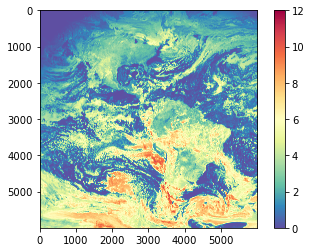

In [48]:
plt.imshow(air_nearest, vmin=0, vmax=12, cmap="Spectral_r")
plt.colorbar()

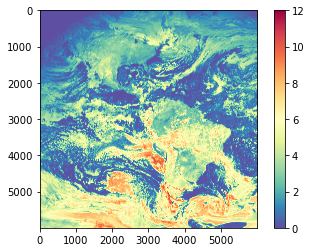

In [49]:
plt.imshow(air_gauss, vmin=0, vmax=12, cmap="Spectral_r")
plt.colorbar()

In [23]:
ds = xr.Dataset(data_vars=dict(L1=(["lat", "lon"], air_nearest)),
                coords=dict(lon=lons,
                            lat=lats,))


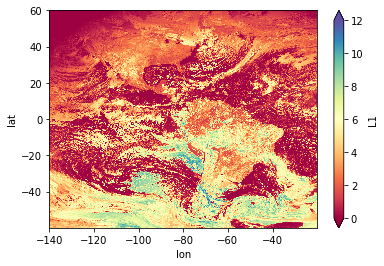

In [30]:
ds.L1.plot.imshow(vmin=0, vmax=12, cmap="Spectral")

In [53]:
from pyresample import bilinear #.XArrayBilinearResampler

In [55]:
bilinear.XArrayBilinearResampler

AttributeError: module 'pyresample.bilinear' has no attribute 'XArrayBilinearResampler'

In [ ]:
pyresample.bilinear.XArrayBilinearResampler(_)

In [ ]:
# interpolating modis to GOES grid

In [5]:
L1B

<xarray.Dataset>
Dimensions:  (band: 6, time: 4, x: 5424, y: 5424)
Coordinates:
    lat      (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    lon      (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
  * band     (band) int64 1 2 3 4 5 6
  * time     (time) object '20203451615' '20203451750' ... '20203452115'
Dimensions without coordinates: x, y
Data variables:
    L1       (time, band, x, y) float32 nan nan nan nan nan ... nan nan nan nan

In [23]:
min_lat, max_lat = np.nanmin(MCD18A1.lat.values)-5, np.nanmax(MCD18A1.lat.values)+5
min_lon, max_lon = np.nanmin(MCD18A1.lon.values)-5, np.nanmax(MCD18A1.lon.values)+5

mask_lon = (L1B.lon >= min_lon) & (L1B.lon <= max_lon)
mask_lat = (L1B.lat >= min_lat) & (L1B.lat <= max_lat)

In [9]:
min_lat, max_lat

(40.00419293327913, 49.99585492947373)

In [10]:
cropped_L1B = L1B.where(mask_lon & mask_lat, drop=True)

In [13]:
cropped_L1B.lat.shape

(365, 1157)

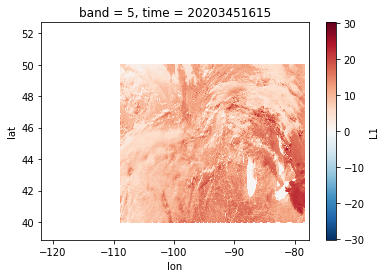

In [29]:
cropped_L1B.L1.sel(band=5).sel(time="20203451615").plot(x='lon', y='lat')

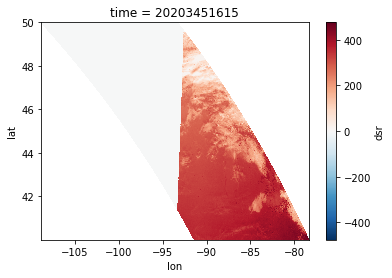

In [30]:
MCD18A1.sel(time="20203451615").dsr.plot(x='lon', y='lat')

In [36]:
mod_interp = MCD18A1.interp(dict(y=cropped_L1B.y, x=cropped_L1B.x), method="nearest")

In [ ]:
geo to metcator on matplotli basemap
pyresample
ask Andy


In [40]:
cropped_L1B

<xarray.Dataset>
Dimensions:  (band: 6, time: 4, x: 365, y: 1157)
Coordinates:
    lat      (x, y) float32 40.017765 40.015785 40.013496 ... 49.9877 49.987297
    lon      (x, y) float32 -108.851746 -108.818634 ... -78.3732 -78.34313
  * band     (band) int64 1 2 3 4 5 6
  * time     (time) object '20203451615' '20203451750' ... '20203452115'
Dimensions without coordinates: x, y
Data variables:
    L1       (time, band, x, y) float32 111.47756 94.08951 ... 0.0018805265

In [41]:
mod_interp

<xarray.Dataset>
Dimensions:  (time: 5, x: 365, y: 1157)
Coordinates:
    lon      (x, y) float64 -108.9 -108.9 -108.9 -108.8 ... -88.47 -88.46 -88.45
    lat      (x, y) float64 50.0 50.0 50.0 50.0 50.0 ... 46.96 46.96 46.96 46.96
  * time     (time) <U11 '20203451615' '20203451750' ... '20203452115'
Dimensions without coordinates: x, y
Data variables:
    dsr      (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    y        (y) int64 0 1 2 3 4 5 6 7 ... 1150 1151 1152 1153 1154 1155 1156
    x        (x) int64 0 1 2 3 4 5 6 7 8 ... 356 357 358 359 360 361 362 363 364

In [6]:
tile = "h01v01"

## ABI-L1b-RadF - Advanced Baseline Imager Level 1b Full Disk

In [15]:
# s20171671145342: is start of scan time
#     4 digit year
#     3 digit day of year
#     2 digit hour
#     2 digit minute
#     2 digit second
#     1 digit tenth of second

In [133]:
def GOES_lat_lon(g16nc, lat_rad_1d, lon_rad_1d):
    # GOES-R projection info and retrieving relevant constants
    proj_info = g16nc.variables['goes_imager_projection']
    lon_origin = -75
    H = 35786023.0+6378137.0
    r_eq = 6378137.0
    r_pol = 6356752.31414

    # create meshgrid filled with radian angles
    lat_rad,lon_rad = np.meshgrid(lat_rad_1d,lon_rad_1d)

    # lat/lon calc routine from satellite radian angle vectors

    lambda_0 = (lon_origin*np.pi)/180.0

    a_var = np.power(np.sin(lat_rad),2.0) + (np.power(np.cos(lat_rad),2.0)*(np.power(np.cos(lon_rad),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(lon_rad),2.0))))
    b_var = -2.0*H*np.cos(lat_rad)*np.cos(lon_rad)
    c_var = (H**2.0)-(r_eq**2.0)

    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)

    s_x = r_s*np.cos(lat_rad)*np.cos(lon_rad)
    s_y = - r_s*np.sin(lat_rad)
    s_z = r_s*np.cos(lat_rad)*np.sin(lon_rad)

    lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    
    return lat, lon


class GeoNEXL1B(object):
    '''
    Get information on L1G data directory, available tiles, years, and files
        file lists are locally cached to future reading as retrieving file lists
        can be time consuming.
    Args:
        data_directory: directory of the L1G product
        sensor: (G16,G17,H8)
    '''
    def __init__(self, data_directory, sensor="G16"):
        self.data_directory = data_directory
        self.sensor = sensor
        self.sat = os.path.basename(os.path.dirname(os.path.dirname(data_directory)))

    def hours(self):
        return list(range(0,24))

    def files(self, year=None, dayofyear=None, hour=None):
        '''
        Args:
            tile (optional): Tile from GeoNEX grid
            year (optional): Year of files to get
            dayofyear (optional): Day of year
        Returns:
            pd.DataFrame of filelist with year, dayofyear, hour, minute, band, file
        '''
        if year == None:
            year = '*'
        else:
            year = str(year)
        if dayofyear == None:
            dayofyear = '*'
        else:
            dayofyear = '%03i' % dayofyear
        if hour == None:
            hour = '*'
        else:
            hour = '%02i' % hour
            
            
        file_pattern = os.path.join(self.data_directory, '%s/%s/%s/*.nc' % (year, dayofyear, hour))
        files = glob.glob(file_pattern)
        fileinfo = []
        for f in files:
            fl = os.path.basename(f).split('_s')[-1]
            y = int(fl[:4])
            doy = int(fl[4:7])
            hour = int(fl[7:9])
            minute = int(fl[9:11])
            b = int(os.path.basename(f).split("M6C")[-1][:2])
            
            fileinfo.append(dict(year=y, dayofyear=doy, hour=hour, minute=minute, band=b, file=f))
        fileinfo = pd.DataFrame(fileinfo)

        return fileinfo
    
    

class L1GFile(object):
    '''
    Reads a single L1B file at a common resolution. Channels are bilinearly interpolated to the defined resolution.
    Args:
        file: Filepath to L1b
        bands (optional): List of bands, default=list(range(1,17))
        resolution_km (optional): Resolution in km for common grid, default=2
    '''
    def __init__(self, file, bands=list((range(1,7))), resolution_km=2.):
        self.files = files
        self.bands = bands
        self.resolution_size = 5424 # 2km
        self.reflective_bands = list(range(1,7))
        self.emissive_bands = list(range(7,17))
        self.lat_lon = None
        

    def load(self, file, band):
        ds = xr.open_dataset(file)
        Rad = np.flipud(ndimage.interpolation.zoom(ds.Rad.values, self.resolution_size/ds.Rad.values.shape[0], order=1))
        
        if self.lat_lon == None:
            lat_rad_1d = ndimage.interpolation.zoom(ds.x.values, self.resolution_size/ds.Rad.values.shape[0], order=1)
            lon_rad_1d = np.flip(ndimage.interpolation.zoom(ds.y.values, self.resolution_size/ds.Rad.values.shape[0], order=1))
            self.lat_lon = GOES_lat_lon(ds, lat_rad_1d, lon_rad_1d)
        
        lat, lon = self.lat_lon[0], self.lat_lon[1]
        data_array = xr.DataArray(data=np.expand_dims(Rad, 0),
                                  dims=["band", "x", "y"],
                                  coords=dict(lat=(["x","y"], lat),
                                              lon=(["x","y"], lon),
                                              band=np.array([band])))
        return data_array
    
    def solar(self):
        fp = SD(self.file, SDC.READ)
        sa = fp.select('Solar_Azimuth').get()[:]
        sz = fp.select('Solar_Zenith').get()[:]
        if sa.shape[0] != self.resolution_size:
            sa = ndimage.interpolation.zoom(sa, self.resolution_size/sa.shape[0], order=1)
            sz = ndimage.interpolation.zoom(sz, self.resolution_size/sz.shape[0], order=1)
        return sa*0.01, sz*0.01
    
    def load_xarray(self, time_stamp):
        Rad_data = [self.load(files[files.band==b].file.values[0], b) for b in self.bands]
        Rad_data = xr.concat(Rad_data, dim="band")
        Rad_data = Rad_data.expand_dims({"time": list([time_stamp])})
        return xr.Dataset({'L1': Rad_data})
        

    
    

In [135]:
# def get_geonex_tiles_from_latlon_l1g(modnc):

directory = '/nex/datapool/geonex/public/GOES16/NOAA-L1B/ABI-L1b-RadF/'
geo = GeoNEXL1B(directory)

L1B = []
for ts in tqdm.tqdm(orbit_time_stamps[:1]):

    yyyy, doy, hh, mm = int(ts[:4]), int(ts[4:7]), int(ts[7:9]), int(ts[9:11])
    files = geo.files(year=yyyy, dayofyear=doy, hour=hh)
    if len(files) > 0:
        files = files[files.minute == np.round(mm, -1)]
    if len(files) > 0:

        geo_data = L1GFile(files, resolution_km=2.).load_xarray(ts)
        L1B.append(geo_data)
    
L1B = xr.concat(L1B, dim="time")
        
    


100%|██████████| 1/1 [00:25<00:00, 25.85s/it]


In [129]:
files

year  dayofyear  hour  minute  band  \
18  2020        345    17      50    16   
19  2020        345    17      50     5   
23  2020        345    17      50    14   
25  2020        345    17      50    15   
27  2020        345    17      50     2   
41  2020        345    17      50     6   
44  2020        345    17      50    12   
50  2020        345    17      50     8   
51  2020        345    17      50    13   
59  2020        345    17      50     4   
60  2020        345    17      50     9   
64  2020        345    17      50     1   
74  2020        345    17      50     3   
77  2020        345    17      50    10   
81  2020        345    17      50    11   
88  2020        345    17      50     7   

                                                 file  
18  /nex/datapool/geonex/public/GOES16/NOAA-L1B/AB...  
19  /nex/datapool/geonex/public/GOES16/NOAA-L1B/AB...  
23  /nex/datapool/geonex/public/GOES16/NOAA-L1B/AB...  
25  /nex/datapool/geonex/public/GOES16/NOAA-L1B/AB...  
27  /nex/datapool/geonex/public/GOES16/NOAA-L1B/AB...  
41  /nex/datapool/geonex/public/GOES16/NOAA-L1B/AB...  
44  /nex/datapool/geonex/public/GOES16/NOAA-L1B/AB...  
50  /nex/datapool/geonex/public/GOES16/NOAA-L1B/AB...  
51  /nex/datapool/geonex/public/GOES16/NOAA-L1B/AB...  
59  /nex/datapool/geonex/public/GOES16/NOAA-L1B/AB...  
60  /nex/datapool/geonex/public/GOES16/NOAA-L1B/AB...  
64  /nex/datapool/geonex/public/GOES16/NOAA-L1B/AB...  
74  /nex/datapool/geonex/public/GOES16/NOAA-L1B/AB...  
77  /nex/datapool/geonex/public/GOES16/NOAA-L1B/AB...  
81  /nex/datapool/geonex/public/GOES16/NOAA-L1B/AB...  
88  /nex/datapool/geonex/public/GOES16/NOAA-L1B/AB...

In [126]:
orbit_time_stamps

['20203451615', '20203451750', '20203451755', '20203451935', '20203452115']

In [84]:
geo_data.assign_coords(time=("time", orbit_time_stamps))

<xarray.Dataset>
Dimensions:  (band: 6, time: 5, x: 5424, y: 5424)
Coordinates:
    lon      (x, y) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    lat      (x, y) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
  * band     (band) int64 1 2 3 4 5 6
  * time     (time) <U11 '20203451615' '20203451750' ... '20203452115'
Dimensions without coordinates: x, y
Data variables:
    L1       (band, x, y) float32 nan nan nan nan nan ... nan nan nan nan nan

In [82]:
data

[<xarray.Dataset>
 Dimensions:  (band: 6, x: 5424, y: 5424)
 Coordinates:
     lon      (x, y) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
     lat      (x, y) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
   * band     (band) int64 1 2 3 4 5 6
 Dimensions without coordinates: x, y
 Data variables:
     L1       (band, x, y) float32 nan nan nan nan nan ... nan nan nan nan nan,
 <xarray.Dataset>
 Dimensions:  (band: 6, x: 5424, y: 5424)
 Coordinates:
     lon      (x, y) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
     lat      (x, y) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
   * band     (band) int64 1 2 3 4 5 6
 Dimensions without coordinates: x, y
 Data variables:
     L1       (band, x, y) float32 nan nan nan nan nan ... nan nan nan nan nan,
 <xarray.Dataset>
 Dimensions:  (band: 6, x: 5424, y: 5424)
 Coordinates:
     lon      (x, y) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
     lat      (x, y) floa

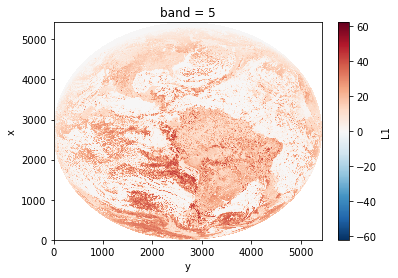

In [66]:
geo_data.L1.sel(band=5).plot()

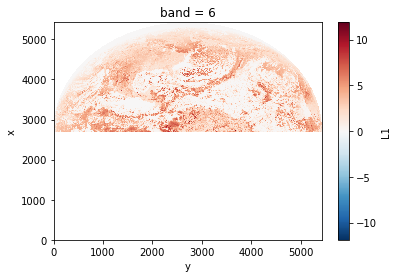

In [71]:
# geo_data.where(geo_data.lat>0).L1.sel(band=6).plot()

In [74]:
# geo_data.where(geo_data.lon<-50).L1.sel(band=6).plot()

In [75]:
# geo_data.lon.plot()

In [76]:
# geo_data.lat.plot()

In [8]:
# MCD18A1.061
# MOD10_L2.061
# MOD04_3K.061 - aerosol
# MOD03.061 - geolocation

In [9]:
def inverse_maps(H,V,size):
    Lat=np.zeros((size,size))
    Lon=np.zeros((size,size))
    R=6371007.181
    T = 1111950
    xmin = -20015109.
    ymax = 10007555.
    w = T /size
    y=np.array([(ymax-(i+.5)*w-V*T) for i in range(size)] )
    x =np.array([((j+.5)*w + (H)*T + xmin) for j in range(size)])
    for i,yy in enumerate(y):
        for j,xx in enumerate(x):
            ll=yy/R
            Lat[i,j]=ll*180/np.pi
            Lon[i,j]=180/np.pi*(xx/(R*np.cos(ll)))
    return Lat,Lon

## MODIS/Terra+Aqua Surface Radiation Daily 3-Hour L3 Global 5 km SIN Grid (MCD18A1.061)

In [10]:
file_name = '/nobackupp13/kmduffy1/MCD18A1.v061/MCD18A1.A2020345.h11v04.061.2021025160154.hdf'
file = SD(file_name, SDC.READ)
datasets_dic = file.datasets()

for idx,sds in enumerate(datasets_dic.keys()):
        print(idx,sds)


0 DSR
1 Direct
2 Diffuse
3 GMT_0000_DSR
4 GMT_0300_DSR
5 GMT_0600_DSR
6 GMT_0900_DSR
7 GMT_1200_DSR
8 GMT_1500_DSR
9 GMT_1800_DSR
10 GMT_2100_DSR
11 DSR_Quality


In [11]:
# get DSR data
sds_obj = file.select('DSR') 
dsr = sds_obj.get()



In [12]:
# calculate lat and lon
tile = os.path.basename(file_name).split(".")[2]
H, V =  int(tile[1:3]), int(tile[4:6])
lat, lon = inverse_maps(H,V,dsr.shape[-1])


In [13]:
# get time stamps
# Orbit_time_stamp contains time information of each overpass in the format of YYYYDDDHHMM:
n_orbits = getattr(file, 'Orbit_amount')
orbit_time_stamps = getattr(file, 'Orbit_time_stamp').split("\n")[:n_orbits]
# time_stamps = [datetime.datetime(int(t[:4]),1,1, int(t[7:9]), int(t[9:11])) + datetime.timedelta(int(t[4:7]) - 1) for t in orbit_time_stamps]
# time_stamps
orbit_time_stamps

['20203451615', '20203451750', '20203451755', '20203451935', '20203452115']

In [14]:
# make Dataset
ds = xr.Dataset(
    data_vars=dict(
        dsr=(["time", "x", "y"], dsr),
    ),
    coords=dict(
        lon=(["x", "y"], lon),
        lat=(["x", "y"], lat),
        time=orbit_time_stamps,
    ),
)


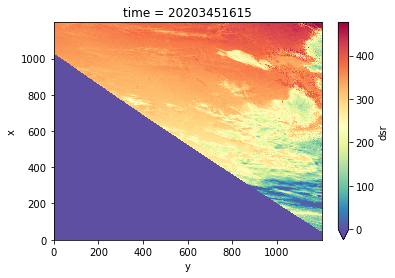

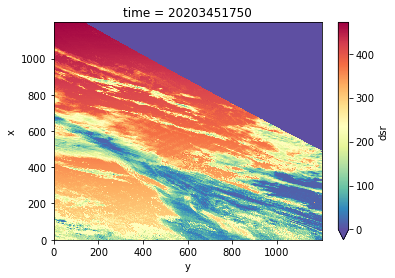

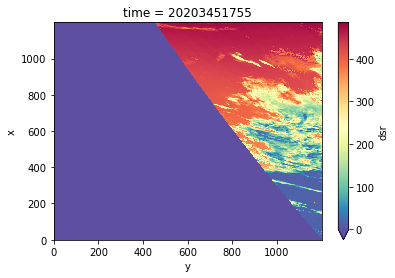

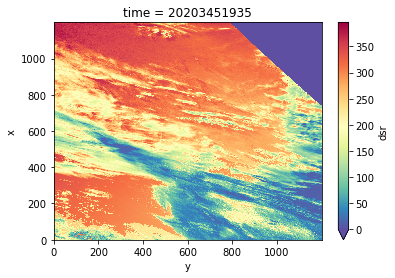

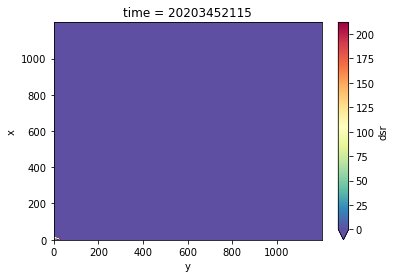

In [34]:
for time in orbit_time_stamps:
    ds.dsr.sel(time=time).plot(vmin=0, cmap="Spectral_r")
    plt.show()

## MODIS/Terra Snow Cover 5-Min L2 Swath 500m, Version 61  (MOD10_L2.061)

In [52]:
# Aquisition dat follows A in file name
# YYYY Acquisition year, DDD Acquisition day of year, HHMM Acquisition hour and minute in Greenwich Mean Time (GMT)
MCD18A1 = ds

In [56]:
data = []
for t in MCD18A1.time.values:
    date, time = t[:-4], t[-4:]
    files = "/nobackupp13/kmduffy1/MOD10L2.v061/MOD10_L2.A%s.%s.*.hdf" %(date, time)
    file_name = glob.glob(files)[0]
    
    file = SD(file_name, SDC.READ)
    sds_obj = file.select('NDSI_Snow_Cover')
    snow_cover = sds_obj.get()
    data.append(snow_cover)
    


# ##### need geolocation data

ds = xr.Dataset(data_vars={snow_cover:(["time", "x", "y"], np.stack(np.array(data)))},
                coords=dict(lon=(["x", "y"], lon),
                            lat=(["x", "y"], lat),
                            time=MCD18A1.time.values))

(5, 4060, 2708)


In [41]:
# need geolocation data

In [48]:
snow_cover

array([[239, 239, 239, ..., 239, 239, 239],
       [239, 239, 239, ..., 239, 239, 239],
       [239, 239, 239, ..., 239, 239, 239],
       ...,
       [239, 239, 239, ..., 239, 239, 239],
       [239, 239, 239, ..., 239, 239, 239],
       [239, 239, 239, ..., 239, 239, 239]], dtype=uint8)

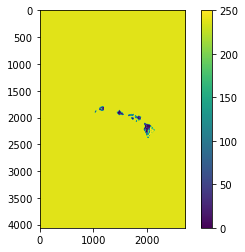

In [44]:
sds_obj = file.select('NDSI_Snow_Cover')
snow_cover = sds_obj.get() 
plt.imshow(snow_cover)
plt.colorbar()


## MOD04_3K - MODIS/Terra Aerosol 5-Min L2 Swath 3km (MOD04_3K.v061)

In [47]:
# file_name = "/nobackupp13/kmduffy1/MOD04_3K/MOD04_3K.A2020345.0645.061.2020346215936.hdf"
# file = SD(file_name, SDC.READ)
# datasets_dic = file.datasets()
# for idx,sds in enumerate(datasets_dic.keys()):
#         print(idx,sds)

### Read 2020 tiles

In [2]:
path = "/nobackupp13/kmduffy1/cross_sensor_training/tiles_terra_G16/2020/*"

#### count number of files for each MODIS tile

In [3]:
files = glob.glob(path)
shuffle(files)
tiles = [f.split(".")[-4] for f in files]
for t in np.unique(tiles):
    print(t, np.sum([ti == t for ti in tiles]))

h05v11 12
h06v11 36
h07v05 65
h07v06 79
h07v07 36
h08v04 78
h08v05 79
h08v06 79
h08v07 79
h08v08 49
h08v09 66
h08v11 38
h09v04 79
h09v05 79
h09v06 79
h09v07 79
h09v08 77
h09v09 77
h10v04 79
h10v05 78
h10v06 78
h10v07 78
h10v08 78
h10v09 77
h10v10 78
h11v04 77
h11v05 77
h11v06 77
h11v07 77
h11v08 77
h11v09 74
h11v10 77
h11v11 79
h11v12 80
h12v04 78
h12v05 72
h12v07 77
h12v08 78
h12v09 77
h12v10 76
h12v11 78
h12v12 78
h12v13 79
h13v04 76
h13v08 36
h13v09 65
h13v10 72
h13v11 75
h13v12 78
h13v13 78
h13v14 80
h14v04 58
h14v09 58
h14v10 59
h14v11 59
h14v14 79
h15v05 44
h15v07 44
h15v11 12
h15v14 52
h16v05 29
h16v06 52


#### plot some sample data

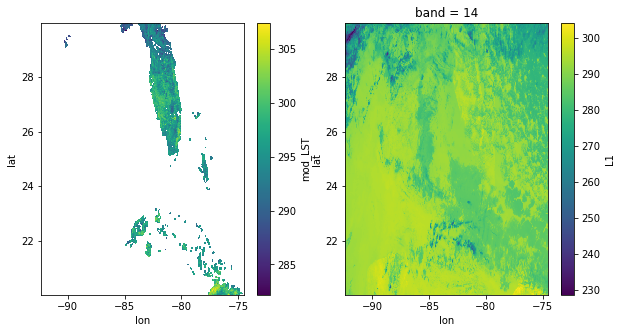

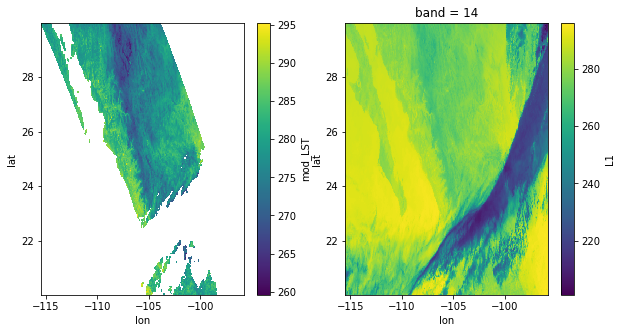

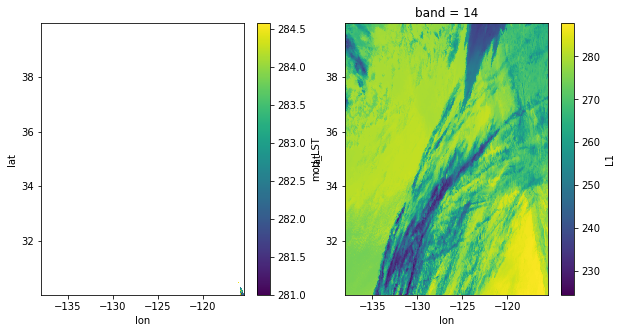

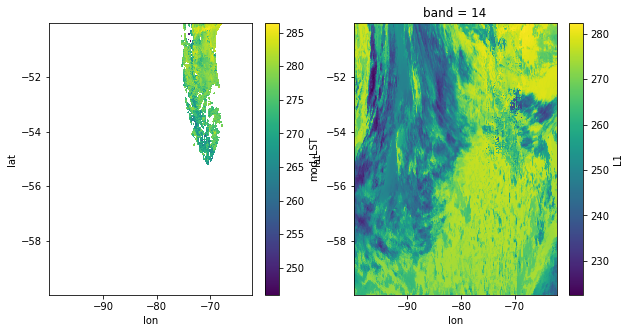

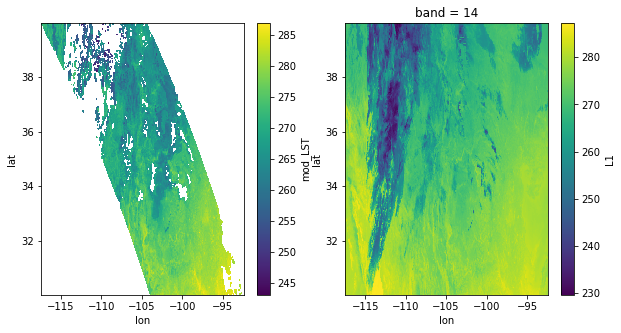

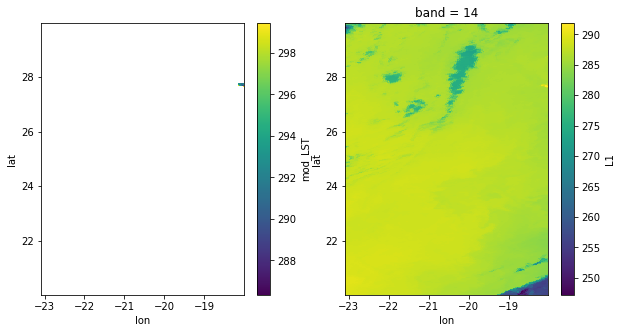

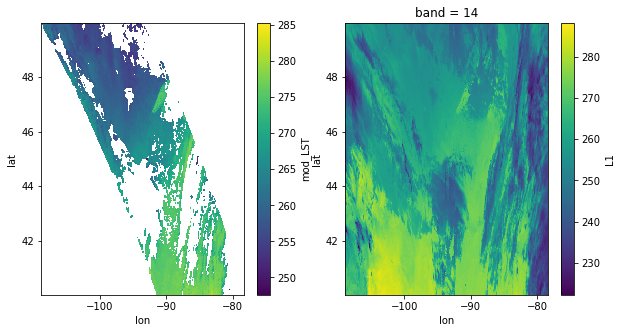

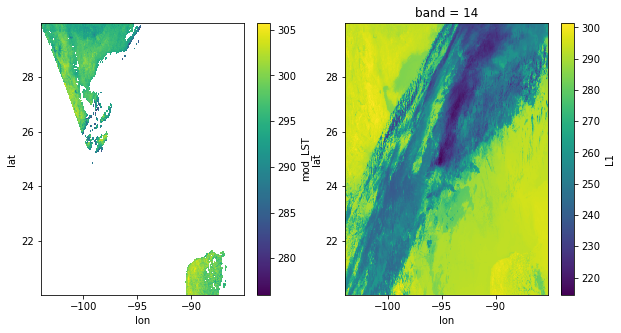

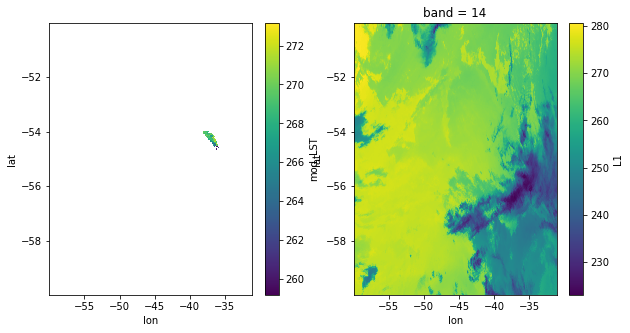

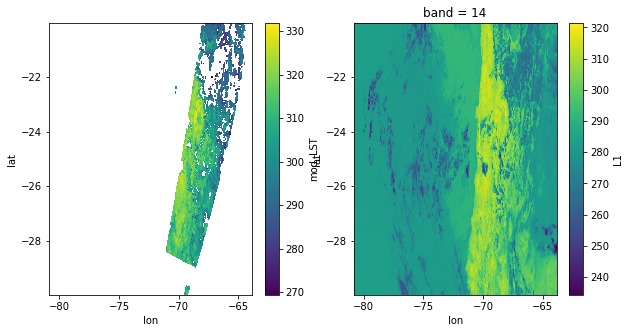

In [4]:
for file in files[:10]:
    ds = xr.open_dataset(file)
    
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    lst = ds.mod_LST.values
    lst[lst<-100] = np.nan
    ds["mod_LST"] = (("lat", "lon"), lst)
    ds.mod_LST.plot(ax=ax[0])    
    ds.L1.sel(band=14).plot(ax=ax[1])
    plt.show()

#### check h08v94 and h09v04

In [5]:
import datetime as dt
from functools import partial
import itertools
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj import Proj
import rasterio
import rioxarray as rxr
import scipy.stats
from sklearn.impute import KNNImputer
import tqdm
import xarray as xr

import warnings
warnings.filterwarnings("ignore")


try:
    import geonexl1g
except:
    import data.geonexl1g as geonexl1g


    
dec2bin_numpy = np.vectorize(partial(np.binary_repr, width = 8))
def last_2(string):
    return int(string[-2:])
snip = np.vectorize(last_2)


def read_MOD11A1(file, scan):


    rds = rxr.open_rasterio(file, variable="LST_%s_1km" %scan)
    LST = rds["LST_%s_1km" %scan].values[0,:,:] * 0.02
    LST[LST < 1e-5] = np.nan
    LST = np.expand_dims(LST, 0)
    rds["LST_%s_1km" %scan] = (("band", "y", "x"), LST)
    LST = rds["LST_%s_1km" %scan].rio.reproject("EPSG:4326")[0,:,:]
    lat, lon = LST.y.values, LST.x.values
    rds.close()

    rds = rxr.open_rasterio(file, variable="Emis_31")
    Emis_31 = rds.Emis_31.values[0,:,:] * 0.002
    Emis_31[Emis_31 < 1e-5] = np.nan
    Emis_31 = np.expand_dims(Emis_31, 0)
    rds["Emis_31"] = (("band", "y", "x"), Emis_31)
    Emis_31 = rds.Emis_31.rio.reproject("EPSG:4326")[0,:,:]
    rds.close()

    rds = rxr.open_rasterio(file, variable="Emis_32")
    Emis_32 = rds.Emis_32.values[0,:,:] * 0.002
    Emis_32[Emis_32 < 1e-5] = np.nan
    Emis_32 = np.expand_dims(Emis_32, 0)
    rds["Emis_32"] = (("band", "y", "x"), Emis_32)
    Emis_32 = rds.Emis_32.rio.reproject("EPSG:4326")[0,:,:]
    rds.close()

    rds = rxr.open_rasterio(file, variable="%s_view_angl" %scan)
    angle = rds["%s_view_angl" %scan].rio.reproject("EPSG:4326")[0,:,:]
    angle = np.where(angle.values == 255., np.nan, angle.values) * 1.0 - 65.0
    rds.close()

    rds = rxr.open_rasterio(file, variable="%s_view_time" %scan)
    time = rds["%s_view_time" %scan].rio.reproject("EPSG:4326")[0,:,:]
    longitude, latitude = np.meshgrid(time.x.values, time.y.values)
    time = np.where(time.values == 255., np.nan, time.values)
    time_UTC = time * 0.1 -  (longitude / 15) 
    time_UTC = np.floor(time_UTC) + np.round(time_UTC % 1. * 60, -1) / 60 # hour + nearest 10 minute
    rds.close()

    rds = rxr.open_rasterio(file, variable="QC_%s" %scan)
    QC = rds["QC_%s" %scan].rio.reproject("EPSG:4326")[0,:,:]
    QC_bit = dec2bin_numpy(QC)
    QC_bit2 = snip(QC_bit)
    rds.close()

    ds = xr.Dataset({"mod_LST": (["lat", "lon"], LST),
                    "Emis_31": (["lat", "lon"], Emis_31),
                     "Emis_32": (["lat", "lon"], Emis_32),
                     "mod_view_angl": (["lat", "lon"], angle),
                     "mod_time_UTC": (["lat", "lon"], time_UTC),
                     "mod_QC": (["lat", "lon"], QC_bit2)},
                      coords={"lat": lat, "lon": lon})
    return ds  


def return_tile(lat, lon):
    lat_0 = 60
    lon_0 = -180
    lat_1 = -60
    lon_1 = 180
    h_lons = np.arange(lon_0, lon_1, 6)
    v_lats = np.arange(lat_0, lat_1, -6)
    
    if (len(np.where(lon > h_lons)[0]) > 0.) and (len(np.where(lat < v_lats)[0]) > 0.):
        h = np.where(lon > h_lons)[0][-1]
        v = np.where(lat < v_lats)[0][-1]    
    else:
        h, v = None, None
        
    return h, v
    
    
def get_geonex_tiles_from_latlon_l1g(mod_file, mod_data, time, sensor="G16"):
    lats, lons = mod_data.lat.values,  mod_data.lon.values
    h_ll, v_ll = return_tile(np.nanmin(lats), np.nanmin(lons)) # ll corner of modis tile
    h_ur, v_ur = return_tile(np.nanmax(lats), np.nanmax(lons)) # ur corner of modis tile
    
    
    concat_tiles = []
    if len(list(filter(None, [h_ll, v_ll, h_ur, v_ur]))) == 4.:
        num_tiles = len(list(itertools.product(np.arange(h_ll, h_ur+1), np.arange(v_ur, v_ll+1))))
        for x in itertools.product(np.arange(h_ll, h_ur+1), np.arange(v_ur, v_ll+1)):
            mod_tile = 'h%02iv%02i' % (x[0], x[1])
            
            if sensor == "G16":
                directory = '/nex/datapool/geonex/public/GOES16/GEONEX-L1G/'
            elif sensor == "H8":
                directory = '/nex/datapool/geonex/public/HIMAWARI8/GEONEX-L1G/'
            geo = geonexl1g.GeoNEXL1G(directory, sensor)
            
            if (mod_tile in geo.tiles()):
                year = int(mod_file.split("/")[-2].split(".")[0])
                month = int(mod_file.split("/")[-2].split(".")[1])
                day = int(mod_file.split("/")[-2].split(".")[2])
                hour, minute = int(np.floor(time)), int(np.round(time % 1. * 60, -1))
                hour = hour-24 if hour>24 else hour+24 if hour<0 else hour
                d = dt.datetime(year, month, day)
                files = geo.files(tile=mod_tile, year=year, dayofyear=d.timetuple().tm_yday)
                if len(files) > 0:
                    files = files[files.hour == hour]
                    files = files[files.minute == minute]  
                    if len(files) > 0.:
                        geo_data = geonexl1g.L1GFile(files['file'].values[0], resolution_km=2.).load_xarray()
                        concat_tiles.append(geo_data)
        
        if len(concat_tiles) > 0:
            for i, tile in enumerate(concat_tiles):
                if i == 0:
                    concat = concat_tiles[0]
                else:
                    concat = concat.merge(tile)
            concat = concat.rename({"zenith":"L1_zenith", "azimuth":"L1_azimuth"})
            return concat


def crop_geo(mod_data, geo_data):
    
    lon_ll, lat_ll = mod_data.lon[0], mod_data.lat[-1]
    lon_ur, lat_ur = mod_data.lon[-1], mod_data.lat[0]

    cropped_geo = geo_data.where(geo_data.lat > lat_ll)
    cropped_geo = cropped_geo.where(cropped_geo.lon > lon_ll)
    cropped_geo = cropped_geo.where(cropped_geo.lat < lat_ur)
    cropped_geo = cropped_geo.where(cropped_geo.lon < lon_ur)
    cropped_geo = cropped_geo.dropna('lat', 'all').dropna('lon', 'all')
        
    return cropped_geo    
    
def closest_nonzero(lst, start_index):
    nonzeros = [(i, x) for i, x in enumerate(lst) if x != 0]
    sorted_nonzeros = sorted(nonzeros, key=lambda x: abs(x[0] - start_index))
    return sorted_nonzeros[0][1]


def time_composite(geo_tiles, times):
    
    if (np.nanmax(times[times == times]) - np.nanmin(times[times == times])) < 1: #then don't do composite
        times[:] = np.nanmean(times) 
        
    mode, count = scipy.stats.mode(times, axis=0)
    mode = mode.flatten()
    mode[mode != mode] = 0.
    emptycols = np.nansum(times, axis=0) == 0.

    for col in range(times.shape[1]):
        if emptycols[col]:
            val = closest_nonzero(list(mode), col)
            times[:,col] =  val
    
    imputer = KNNImputer(missing_values=np.nan, n_neighbors=1)
    times_fill = imputer.fit_transform(times)
    times_unique = np.unique(times[times==times])
    x = np.subtract.outer(times_fill, times_unique)
    y = np.argmin(abs(x), axis=-1)
    times_fill = times_unique[y]
    
    L1_zenith = np.zeros_like(geo_tiles[0].L1_zenith.values)
    for i, t in enumerate(times_unique):
        L1_zenith = np.where(times_fill == t, geo_tiles[i].L1_zenith.values, L1_zenith)

    L1_azimuth = np.zeros_like(geo_tiles[0].L1_azimuth.values)
    for i, t in enumerate(times_unique):
        L1_azimuth = np.where(times_fill == t, geo_tiles[i].L1_azimuth.values, L1_zenith)

    L1 = np.zeros_like(geo_tiles[0].L1.values)
    for i, t in enumerate(times_unique):
        times_fill_L1 = np.repeat(times_fill[...,np.newaxis], L1.shape[-1], axis=-1)
        L1 = np.where(times_fill_L1 == t, geo_tiles[i].L1.values, L1)   
        
    out = geo_tiles[0].copy()
    out["L1"] = (("lat", "lon", "band"), L1)
    out["L1_zenith"] = (("lat", "lon"), L1_zenith)
    out["L1_azimuth"] = (("lat", "lon"), L1_azimuth)
    
    return out


def get_elevation(ds, elevation):
    
        y1, y2 = np.min(ds.lat.values)-1, np.max(ds.lat.values)+1
        x1, x2 = np.min(ds.lon.values)-1, np.max(ds.lon.values)+1
        elevation_patch =  elevation.sel(y=slice(y1, y2)).sel(x=slice(x1, x2))

        elevation_patch.load()
        elevation_patch = elevation_patch.interpolate_na(dim="x", method="linear")
        elevation_patch = elevation_patch.interp(y=ds.lat, x=ds.lon)
        return elevation_patch.z.values/8518.0
    
    
def check_inside_scan(ds):
    if (np.sum(ds.mod_LST < 0) == 0.):
        return True
    else:
        return False

    
def check_valid_LST(ds):
    if (np.sum(ds.mod_LST == ds.mod_LST) > 500.):
        return True
    else:
        return False
    
    
def check_valid_L1(ds):
    if (np.sum(ds.L1.values != ds.L1.values) == 0) & (np.nansum(ds.L1.sel(band=slice(7,16)).values < 1e-6) < 1):
        return True
    else:
        return False
    
    
def make_patches(ds, mod_file, save_dir, size=63, stride=64):

    i_dim = ds.mod_LST.shape[0]
    j_dim = ds.mod_LST.shape[1]

    for i in np.arange(0, i_dim-size, stride):
        for j in np.arange(0, j_dim-size, stride):

            lats, lons = ds.lat, ds.lon
            ds_patch = ds.sel(lat=slice(lats[i], lats[i+size])).sel(lon=slice(lons[j], lons[j+size]))
            
            in_scan = check_inside_scan(ds_patch)
            valid_LST = check_valid_LST(ds_patch)
            valid_L1 = check_valid_L1(ds_patch)
            
            # keep 1/3 of patches with all cloud/water
            if not valid_L1:
                if np.random.uniform(low=0, high=1, size=1) > 2/3:
                    valid_L1 == True

            if in_scan & valid_LST & valid_L1:

                fname = mod_file.split("/")[-1].split(".hdf")[0] + "_lat_%s_lon_%s.nc" %(np.round(lats[i].values,2), np.round(lons[j].values,2))
                ds_patch.to_netcdf(save_dir + fname)      
                ds_patch.close()


    


# def prepare_tiles(date, LEO_sensor, GEO_sensor):

#     elevation = glob.glob("/nobackupp13/kmduffy1/SRTM30/*")
#     elevation_ds = xr.open_mfdataset(elevation, combine="by_coords")

#     year = date.split(".")[0]
#     tile_save_dir = "/nobackupp13/kmduffy1/cross_sensor_training/tiles_%s_%s/%s/" %(LEO_sensor, GEO_sensor, year)
#     patch_save_dir = "/nobackupp13/kmduffy1/cross_sensor_training/patches_%s_%s/%s/" %(LEO_sensor, GEO_sensor, year)


#     if LEO_sensor == "terra":
#         mod11 = glob.glob("/nex/datapool/modis/MOD11A1.006/%s/*" %date)
#     elif LEO_sensor == "aqua":
#         mod11 = glob.glob("/nex/datapool/modis/MYD11A1.006/%s/*" %date)
    
    
    
#     for mod_file in tqdm.tqdm(mod11):
#         for scan in ["Day", "Night"]:
            
#             try:

#                 mod_data = read_MOD11A1(mod_file, scan)

#                 if (mod_data.lat.values.mean() > -60) & (mod_data.lat.values.mean() < 60):


#                     times = np.round(mod_data.mod_time_UTC.values,3)
#                     geo_tiles = [get_geonex_tiles_from_latlon_l1g(mod_file, mod_data, time, GEO_sensor) for time in np.unique(times[times == times])]

#                     geo_tiles = list(filter(None, geo_tiles))
#                     if (len(geo_tiles)> 0) & (len(geo_tiles) == len(np.unique(times[times == times]))):

#                         cropped_geo_tiles = [crop_geo(mod_data, tile) for tile in geo_tiles]

#                         mod_interp = mod_data.interp(dict(lat=cropped_geo_tiles[0].lat, lon=cropped_geo_tiles[0].lon), method="nearest")
#                         mod_interp_times = mod_data.interp(dict(lat=cropped_geo_tiles[0].lat, lon=cropped_geo_tiles[0].lon), method="nearest")
#                         times = np.round(mod_interp_times.mod_time_UTC.values,3)

#                         geo_data = time_composite(cropped_geo_tiles, times)
#                         pair = geo_data.merge(mod_interp)

#                         elevation = get_elevation(pair, elevation_ds)
#                         pair["elevation"] = (("lat", "lon"), elevation)   

#                         fname = mod_file.split("/")[-1].split(".hdf")[0] + "_" + scan + ".nc"
#                         pair.to_netcdf(tile_save_dir + fname) 
#                         print("saved ", tile_save_dir + fname)


#                         if year == "2019":
#                             make_patches(pair, mod_file, patch_save_dir, size=63)
#                             pair.close()
     
                        
#             except:
#                 print("error on ", scan, mod_file)

In [6]:
scan, LEO_sensor, GEO_sensor = "Day", "terra", "G16"

In [8]:
LEO_sensor, GEO_sensor, scan = "Terra", "G16", "Night"
mod_file = "/nex/datapool/modis/MOD11A1.006/2020.01.28/MOD11A1.A2020028.h16v06.006.2020029091045.hdf"
mod_data = read_MOD11A1(mod_file, scan)

elevation = glob.glob("/nobackupp13/kmduffy1/SRTM30/*")
elevation_ds = xr.open_mfdataset(elevation, combine="by_coords")

if (mod_data.lat.values.mean() > -60) & (mod_data.lat.values.mean() < 60):

    times = np.round(mod_data.mod_time_UTC.values,3)
    geo_tiles = [get_geonex_tiles_from_latlon_l1g(mod_file, mod_data, time, GEO_sensor) for time in np.unique(times[times == times])]

    geo_tiles = list(filter(None, geo_tiles))
    if (len(geo_tiles)> 0) & (len(geo_tiles) == len(np.unique(times[times == times]))):

        cropped_geo_tiles = [crop_geo(mod_data, tile) for tile in geo_tiles]

        mod_interp = mod_data.interp(dict(lat=cropped_geo_tiles[0].lat, lon=cropped_geo_tiles[0].lon), method="nearest")
        mod_interp_times = mod_data.interp(dict(lat=cropped_geo_tiles[0].lat, lon=cropped_geo_tiles[0].lon), method="nearest")
        times = np.round(mod_interp_times.mod_time_UTC.values,3)

        geo_data = time_composite(cropped_geo_tiles, times)
        pair = geo_data.merge(mod_interp)

        elevation = get_elevation(pair, elevation_ds)
        pair["elevation"] = (("lat", "lon"), elevation)   

        fname = mod_file.split("/")[-1].split(".hdf")[0] + "_" + scan + ".nc"
#         pair.to_netcdf(tile_save_dir + fname) 
#         print("saved ", tile_save_dir + fname)


#         if year == "2019":
#             make_patches(pair, mod_file, patch_save_dir, size=63)
#             pair.close()
     
                        


ValueError: zero-size array to reduction operation fmax which has no identity

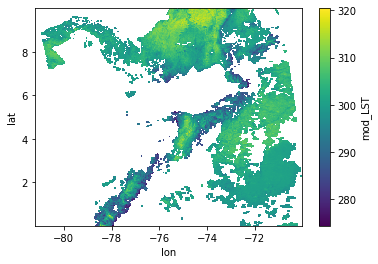

In [17]:
lst = pair.mod_LST.values
lst[lst<-100] = np.nan
pair["mod_LST"] = (("lat", "lon"), lst)
pair.mod_LST.plot()  


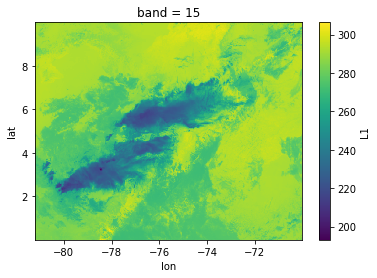

In [18]:
pair.L1.sel(band=15).plot()